# AGGRESSION ANALYSIS
## Pre-processing and Training Data Development 

### By Dwayne Negron

### A predictive model on the chances of Theft occuring in the Orlando, FL area by utilizing state-reported city police data. 

In [1]:
#Loading our tools
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split

### Load in Dataset & Elimination of NaN's

Elimination and processing of NaN's was covered in the EDA documentation. 

In [46]:
df = pd.read_csv("OPD_Crimes.csv", parse_dates = ['Case Date Time'])
df = df.dropna().reset_index(drop=True)
df.head()

Case Number      Case Date Time                      Case Location  \
0  2019-00035680 2019-01-26 20:43:00     4900 Block of INTERNATIONAL DR   
1  2019-00055610 2019-02-10 17:01:00     6300 Block of INTERNATIONAL DR   
2  2019-00060404 2019-02-14 07:54:00  800 Block of S ORANGE BLOSSOM TRL   
3  2019-00101813 2019-03-16 11:11:00           5800 Block of RALEIGH ST   
4  2019-00123720 2019-04-02 12:31:00            1800 Block of W GORE ST   

  Case Offense Location Type Case Offense Category  Case Offense Type  \
0                       Mall                 Theft        Shoplifting   
1                Hotel/Motel                 Theft  All other larceny   
2          Convenience Store                 Theft  All other larceny   
3          Convenience Store                 Theft        Shoplifting   
4      Parking Lot - Surface                 Theft  All other larceny   

  Case Offense Charge Type Case Disposition  Status  \
0                Committed           Arrest  Mapped   
1                Committed           Closed  Mapped   
2                Committed           Closed  Mapped   
3                Committed           Closed  Mapped   
4                Committed           Closed  Mapped   

                      Location  
0  (28.47391409, -81.44958996)  
1  (28.46083797, -81.46763256)  
2  (28.53157189, -81.39713307)  
3  (28.52796144, -81.46080022)  
4  (28.53103565, -81.40445914)

### Feature Additions

We left our EDA knowing that to create a more successful Machine Model we would have to introduce additional features. To do so we included the following: 
- Date Time variables 
- Dummy Values demarking Theft and Larceny Crime Presence 
- Latitude & Longitude
- Academic Season [Fall, Spring, Summer, Break]


In [3]:
#Let us add some Date Time features alongside the boolean values for Theft and Larceny

df['Date'] = df['Case Date Time'].dt.date
df['Year'] = df['Case Date Time'].dt.year
df['Month'] = df['Case Date Time'].dt.month
df['Day'] = df['Case Date Time'].dt.dayofweek
df['DayLinear']= df['Case Date Time'].dt.day
df['Hour'] = df['Case Date Time'].dt.hour

In [4]:
#Let us seperate our Location into Latitude & Longitude
df['Latitude'] = df['Location'].str.split(', ').str[0]
df['Latitude'] = [b.strip('(') for b in df['Latitude']]
df['Longitude'] = df['Location'].str.split(', ').str[1]
df['Longitude'] = [b.strip(')') for b in df['Longitude']]
df[['Latitude','Longitude']].head()

Latitude     Longitude
0  28.47391409  -81.44958996
1  28.46083797  -81.46763256
2  28.53157189  -81.39713307
3  28.52796144  -81.46080022
4  28.53103565  -81.40445914

In [5]:
df['Season'] = df['Month'].copy()
df['Fall'] = df['Month'] <= 4
#df['Season'].where(df['Month'] > 4 and df['Month'] <= 6, 3)
df['Break'] = df['Month'] == 7
df['Spring'] = df['Month'] >= 8
tmp = df['Month'] > 4
df['Summer'] = tmp[tmp <7]

df[['Fall','Break','Spring','Summer']].head()

Fall  Break  Spring  Summer
0  True  False   False   False
1  True  False   False   False
2  True  False   False   False
3  True  False   False   False
4  True  False   False   False

In [6]:
df[['Fall','Break','Spring','Summer']].value_counts()

Fall   Break  Spring  Summer
False  False  True    True      88667
True   False  False   False     69005
False  False  False   True      36726
       True   False   True      18581
dtype: int64

In [7]:
dummy = pd.get_dummies(df['Case Offense Category'])
dummy.head()

Arson  Assault  Bribery  Burglary  Embezzlement  Fraud  Homicide  \
0      0        0        0         0             0      0         0   
1      0        0        0         0             0      0         0   
2      0        0        0         0             0      0         0   
3      0        0        0         0             0      0         0   
4      0        0        0         0             0      0         0   

   Kidnapping  Narcotics  Robbery  Theft  Vehicle Theft  
0           0          0        0      1              0  
1           0          0        0      1              0  
2           0          0        0      1              0  
3           0          0        0      1              0  
4           0          0        0      1              0

In [8]:
df = pd.concat([df,dummy], axis=1)
df.head()

index    Case Number      Case Date Time  \
0    100  2019-00035680 2019-01-26 20:43:00   
1    114  2019-00055610 2019-02-10 17:01:00   
2    116  2019-00060404 2019-02-14 07:54:00   
3    142  2019-00101813 2019-03-16 11:11:00   
4    156  2019-00123720 2019-04-02 12:31:00   

                       Case Location Case Offense Location Type  \
0     4900 Block of INTERNATIONAL DR                       Mall   
1     6300 Block of INTERNATIONAL DR                Hotel/Motel   
2  800 Block of S ORANGE BLOSSOM TRL          Convenience Store   
3           5800 Block of RALEIGH ST          Convenience Store   
4            1800 Block of W GORE ST      Parking Lot - Surface   

  Case Offense Category  Case Offense Type Case Offense Charge Type  \
0                 Theft        Shoplifting                Committed   
1                 Theft  All other larceny                Committed   
2                 Theft  All other larceny                Committed   
3                 Theft        Shoplifting                Committed   
4                 Theft  All other larceny                Committed   

  Case Disposition  Status  ... Bribery Burglary  Embezzlement  Fraud  \
0           Arrest  Mapped  ...       0        0             0      0   
1           Closed  Mapped  ...       0        0             0      0   
2           Closed  Mapped  ...       0        0             0      0   
3           Closed  Mapped  ...       0        0             0      0   
4           Closed  Mapped  ...       0        0             0      0   

   Homicide  Kidnapping  Narcotics Robbery Theft  Vehicle Theft  
0         0           0          0       0     1              0  
1         0           0          0       0     1              0  
2         0           0          0       0     1              0  
3         0           0          0       0     1              0  
4         0           0          0       0     1              0  

[5 rows x 36 columns]

In [9]:
#What are our features? 
for column in df:
    print(column)

index
Case Number
Case Date Time
Case Location
Case Offense Location Type
Case Offense Category
Case Offense Type
Case Offense Charge Type
Case Disposition
Status
Location
Date
Year
Month
Day
DayLinear
Hour
Latitude
Longitude
Season
Fall
Break
Spring
Summer
Arson
Assault
Bribery
Burglary
Embezzlement
Fraud
Homicide
Kidnapping
Narcotics
Robbery
Theft
Vehicle Theft


In [10]:
# Lets isolate our numerical features
# We decided to add to our feature set in three steps to see how they would affect our modelling f1 scores. 
feature_names = ['Year','Month','Day','DayLinear','Hour']

X = df[feature_names]
y = df['Theft']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
print(X,y)

        Year  Month  Day  DayLinear  Hour
0       2019      1    5         26    20
1       2019      2    6         10    17
2       2019      2    3         14     7
3       2019      3    5         16    11
4       2019      4    1          2    12
...      ...    ...  ...        ...   ...
212974  2014     10    5         11    10
212975  2013      1    6         13    14
212976  2011      1    2          5    13
212977  2013      2    1         19    15
212978  2011     10    0         17    17

[212979 rows x 5 columns] 0         1
1         1
2         1
3         1
4         1
         ..
212974    1
212975    1
212976    0
212977    0
212978    1
Name: Theft, Length: 212979, dtype: uint8


### Logistic Regression

In [11]:
# Logistic Regression 1 - Date Time Features
logreg_results = {}
logreg = LogisticRegression()
logreg
logreg.fit(X_train,y_train)
logreg.coef_

array([[-0.00012417,  0.01376247, -0.00753129,  0.00178765,  0.0139125 ]])

In [12]:
y_pred = logreg.predict(X_test)

In [13]:
print("Linear Regression Feature Set 1")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred))
logreg_results['Set1'] =  metrics.f1_score(y_test,y_pred)

Linear Regression Feature Set 1
Accuracy: 0.5194290543713025
Balanced accuracy: 0.5180043727792443
Precision score 0.5201540127541812
Recall score 0.6421568627450981
F1 Score 0.5747523765206408


In [14]:
#LogisticRegression 2 - Date Time Features + Long / Lat 

In [15]:
feature_names = ['Year','Month','Day','DayLinear','Hour', 'Longitude', 'Latitude']

X = df[feature_names]
y = df['Theft']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg2 = LogisticRegression()
logreg2.fit(X_train,y_train)
logreg2.coef_

array([[ 0.05877427,  0.01255512, -0.01494228,  0.00179684,  0.01440278,
         1.15091113, -0.87431214]])

In [16]:
y_pred = logreg2.predict(X_test)

In [17]:
print("Linear Regression Feature Set 2")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred))
logreg_results['Set2'] =  metrics.f1_score(y_test,y_pred)

Linear Regression Feature Set 2
Accuracy: 0.5408395154474599
Balanced accuracy: 0.5403906299618002
Precision score 0.5431604594500522
Recall score 0.5795083184789067
F1 Score 0.5607459844047575


In [18]:
#LogisticRegression 3 - Date Time Features + Long / Lat + Academic Seasons

In [19]:
feature_names = ['Year','Month','Day','DayLinear','Hour', 'Longitude', 'Latitude', 'Spring', 'Fall', 'Break', 'Summer']

X = df[feature_names]
y = df['Theft']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg3 = LogisticRegression()
logreg3.fit(X_train,y_train)
logreg3.coef_

/home/dn/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[ 0.04047601,  0.01316968, -0.01531205,  0.00154652,  0.01421052,
         0.79298146, -0.60239552, -0.15327637, -0.0817431 ,  0.14494641,
         0.07430607]])

In [20]:
y_pred = logreg3.predict(X_test)

In [21]:
print("Linear Regression Feature Set 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred))
logreg_results['Set3'] =  metrics.f1_score(y_test,y_pred)

Linear Regression Feature Set 3
Accuracy: 0.5367827965067142
Balanced accuracy: 0.5362316388630318
Precision score 0.5387644681871104
Recall score 0.5842617349970292
F1 Score 0.5605914840548727


In [22]:
feature_names = ['Year','Month','Day','DayLinear','Hour', 'Longitude', 'Latitude', 'Spring', 'Fall', 'Break', 'Summer', 'Arson', 'Assault', 'Bribery','Burglary','Embezzlement','Fraud','Homicide','Kidnapping','Narcotics','Robbery', 'Vehicle Theft']

X = df[feature_names]
y = df['Theft']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg4 = LogisticRegression()
logreg4.fit(X_train,y_train)
logreg4.coef_

/home/dn/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[ 1.16310017e-01,  2.66110996e-03, -3.11598381e-02,
         3.04757964e-03,  3.20654320e-02,  2.23156581e+00,
        -1.69561208e+00, -4.43885221e-01, -2.20249569e-01,
         4.05843428e-01,  1.99325285e-01, -2.97869604e-01,
        -2.65972817e+01,  0.00000000e+00, -3.18797285e+01,
        -6.52911836e-02, -1.62482612e+01, -2.24136377e-01,
        -1.24613277e-01, -2.52388614e+01, -6.86649145e+00,
        -1.24835972e+01]])

In [23]:
print("Linear Regression Feature Set 4")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred))
logreg_results['Set4'] =  metrics.f1_score(y_test,y_pred)

Linear Regression Feature Set 4
Accuracy: 0.5367827965067142
Balanced accuracy: 0.5362316388630318
Precision score 0.5387644681871104
Recall score 0.5842617349970292
F1 Score 0.5605914840548727


In [24]:
print(logreg_results)

{'Set1': 0.5747523765206408, 'Set2': 0.5607459844047575, 'Set3': 0.5605914840548727, 'Set4': 0.5605914840548727}


### Confusion Matrix w/ Dummy Values for Category

Text(0.5, 257.44, 'Predicted label')

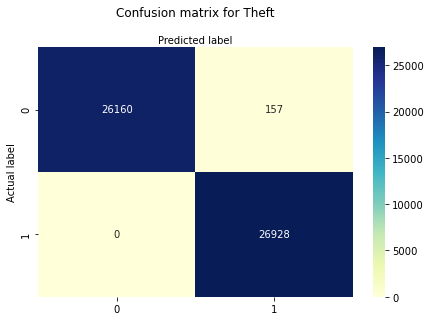

In [25]:
from sklearn import metrics
y_pred = logreg4.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Theft', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Confusion Matrix w/o Dummy Values for Category

In [26]:
feature_names = ['Year','Month','Day','DayLinear','Hour', 'Longitude', 'Latitude', 'Spring', 'Fall', 'Break', 'Summer']

X = df[feature_names]
y = df['Theft']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg3 = LogisticRegression()
logreg3.fit(X_train,y_train)
y_pred = logreg3.predict(X_test)

/home/dn/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
from sklearn import metrics
y_pred = logreg3.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Theft', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 257.44, 'Predicted label')

# Random Forest w/o Dummy Features For Category

In [28]:
firstRFModel = RandomForestClassifier(max_depth= 3, random_state= 1234)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
firstRFModel.fit(X_train, y_train)

y_pred = firstRFModel.predict(X_test)
y_pred = pd.Series(y_pred)
firstRFModel

RandomForestClassifier(max_depth=3, random_state=1234)

In [29]:
randtree_results = {}
print("Random Forest Model Depth=3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred)) 
randtree_results['Depth3'] = metrics.f1_score(y_test,y_pred)

Random Forest Model Depth=3
Accuracy: 0.6166212789933327
Balanced accuracy: 0.6157152848657612
Precision score 0.6054309479884779
Recall score 0.6946672608437314
F1 Score 0.646986597492434


In [30]:
secondRFModel = RandomForestClassifier(max_depth= 4, random_state= 1234)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
secondRFModel.fit(X_train, y_train)

y_pred = secondRFModel.predict(X_test)
y_pred = pd.Series(y_pred)
secondRFModel

RandomForestClassifier(max_depth=4, random_state=1234)

In [31]:
print("Random Forest Model Depth=4")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred)) 
randtree_results['Depth4'] = metrics.f1_score(y_test,y_pred)

Random Forest Model Depth=4
Accuracy: 0.6248849657244812
Balanced accuracy: 0.6242275071627157
Precision score 0.6168946855356483
Recall score 0.6815210932857991
F1 Score 0.6475995553751963


In [32]:
thirdRFModel = RandomForestClassifier(max_depth= 5, random_state= 1234)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
thirdRFModel.fit(X_train, y_train)

y_pred = thirdRFModel.predict(X_test)
y_pred = pd.Series(y_pred)
thirdRFModel

RandomForestClassifier(max_depth=5, random_state=1234)

In [33]:
print("Random Forest Model Depth=5")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred)) 
randtree_results['Depth5'] = metrics.f1_score(y_test,y_pred)

Random Forest Model Depth=5
Accuracy: 0.6329044980749367
Balanced accuracy: 0.6320508707357038
Precision score 0.6203691625358727
Recall score 0.7064393939393939
F1 Score 0.6606125850812614


In [34]:
fourthRFModel = RandomForestClassifier(random_state= 1234)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
fourthRFModel.fit(X_train, y_train)

y_pred = fourthRFModel.predict(X_test)
y_pred = pd.Series(y_pred)
fourthRFModel

RandomForestClassifier(random_state=1234)

In [35]:
print("Random Forest Model Depth=Unlimited")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred)) 
randtree_results['Unlimited'] = metrics.f1_score(y_test,y_pred)

Random Forest Model Depth=Unlimited
Accuracy: 0.674711240492065
Balanced accuracy: 0.6746709868963378
Precision score 0.6784812007727745
Recall score 0.6781788472964944
F1 Score 0.6783299903424709


In [43]:
print(randtree_results)

{'Depth3': 0.646986597492434, 'Depth4': 0.6475995553751963, 'Depth5': 0.6606125850812614, 'Unlimited': 0.6783299903424709}


In [36]:
# Random Forest w/ Dummy Features for Category

In [37]:
feature_names = ['Year','Month','Day','DayLinear','Hour', 'Longitude', 'Latitude', 'Spring', 'Fall', 'Break', 'Summer', 'Arson', 'Assault', 'Bribery','Burglary','Embezzlement','Fraud','Homicide','Kidnapping','Narcotics','Robbery', 'Vehicle Theft']

X = df[feature_names]
y = df['Theft']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
firstRFModel.fit(X_train, y_train)

y_pred = firstRFModel.predict(X_test)
y_pred = pd.Series(y_pred)
firstRFModel

RandomForestClassifier(max_depth=3, random_state=1234)

In [38]:
randtree_dummy_results = {}
print("Random Forest Model Depth=3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred)) 
randtree_dummy_results['Depth3'] = metrics.f1_score(y_test,y_pred)

Random Forest Model Depth=3
Accuracy: 0.9756784674617335
Balanced accuracy: 0.9753961317779383
Precision score 0.9541154377635263
Recall score 1.0
F1 Score 0.9765190114413157


In [39]:
secondRFModel = RandomForestClassifier(max_depth= 4, random_state= 1234)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
secondRFModel.fit(X_train, y_train)

y_pred = secondRFModel.predict(X_test)
y_pred = pd.Series(y_pred)
secondRFModel

RandomForestClassifier(max_depth=4, random_state=1234)

In [41]:
print("Random Forest Model Depth=4")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))
print('F1 Score' , metrics.f1_score(y_test,y_pred)) 
randtree_dummy_results['Depth4'] = metrics.f1_score(y_test,y_pred)

Random Forest Model Depth=4
Accuracy: 0.996018405484083
Balanced accuracy: 0.9959721852794772
Precision score 0.9921886514369934
Recall score 1.0
F1 Score 0.9960790116150035


In [42]:
print(randtree_dummy_results)

{'Depth3': 0.9765190114413157, 'Depth4': 0.9960790116150035}


# Conclusion

Dummy features [Academic Season & ] siginificantly helped the F1 score of our model with logistic regression. Utilizing the dummy features for our Theft Category drastically changed our Confusion Matrix. Train-test split was used to help verify the quality of our model and prevent overfitting. This is evident in our first effort to perform a Random Forest Model. When performing a Depth unlimited test, the F1 score on the non split sample pool was 99% compared to 67.8% on the split sample pool. Using the dummy features [Theft Category] on our Random Forest Model drastically changed its F1 score and its ability to overfit. 